# 회귀 실습 : 캐글 주택 가격_고급 회귀 기법

- 데이터  

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data  

- train.csv  다운로드 받아서 house_price.csv로 저장

**house_price 데이터** 
- 79개의 변수로 구성
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

**성능 평가 : RMSLE(Root Mean Squared Log Error)**

**전체 회귀 분석 과정**
- 데이터 전처리
- 선형 회귀 모델 학습/예측/평가
- 회귀 트리 모델 학습/에측/평가
- 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 스태킹 앙상블 모델을 통한 회귀 예측

## 데이터 전처리(Preprocessing)

### 테이터 탐색
- 결측치 확인
- 피처(변수)별 분포

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
house_df_org = pd.read_csv('./Datasets/house_price.csv')
house_df = house_df_org.copy()  # 데이터 가공을 많이 하므로 복사해서 사용
house_df.head(3)

# Target 값 : SalePrice (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


주요 피처들

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet      
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet      
- GarageArea: Size of garage in square feet      
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	  
- OverallCond: Rates the overall condition of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average	  
       5	Average  
       4	Below Average	  
       3	Fair  
       2	Poor  
       1	Very Poor  
- YearBuilt: Original construction date  
- Neighborhood: Physical locations within Ames city limits  
   Blmngtn  Bloomington Heights  
   Blueste  Bluestem  
   BrDale   Briardale  
   .....

- RoofMatl: Roof material  
	ClyTile	Clay or Tile  
	CompShg	Standard (Composite) Shingle  
	Membran	Membrane  
	Metal	Metal  
	.....

- RoofStyle: Type of roof  
	Flat	Flat  
	Gable	Gable  
	Gambrel	Gabrel (Barn)  
	.....

**데이터 타입 확인**

In [10]:
house_df.shape

(1460, 81)

In [11]:
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

**Null 컬럼 및 갯수 확인**

In [16]:
# Null 컬럼 확인 : Null이 있는 컬럼 그 그 건수를 내림차순으로 출력
isnull_series = house_df.isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [ ]:
# 참고 : 전체 피처들의 Null 수 확인


In [ ]:
# 참고 : 데이터 타입별 수 : 시리즈 인덱스 확인


In [ ]:
# 참고 : 시리즈 값 


### 회귀 모델 적용하기 전에 타깃(y) 값의 분포가 대칭 분포인지 확인

**타겟값 SalePrice의 분포 확인**

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

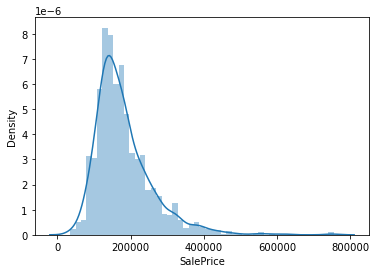

In [17]:
sns.distplot(house_df['SalePrice'])

**SalePrice의 로그 변환**

In [18]:
# SalePrice 로그 변환
log_SalePrice = np.log1p(house_df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

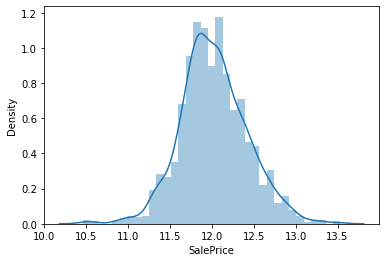

In [19]:
# 결과값을 로그 변환하고 다시 분포도 확인
sns.distplot(log_SalePrice)

### 결측치 처리

In [22]:
# Null 컬럼과 그 건수 출력


Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 62, dtype: int64

In [ ]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [ ]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

In [ ]:
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace=True)

In [ ]:
# Null 값이 있는 피처명과 타입 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
house_df.dtypes[null_column_count.index]

In [ ]:
# 참고 : Null의 개수 확인


### 원-핫 인코딩 변환

: 문자열값은 모두 카테고리값. 판다스의 get_dummies( )를 이용하여 원-핫 인코딩 수행

In [24]:
# 원-핫 인코딩 수행 전/후 데이터 shape 출력
house_df.shape

(1460, 81)

In [25]:
house_df_ohe = pd.get_dummies(house_df)
house_df_ohe.shape

(1460, 290)

In [ ]:
# Null 피처의 Type
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
house_df_ohe.dtypes[null_column_count.index]

## 선형 회귀 모델의 학습/예측/평가

LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델 만들기

**RMSE 평가 함수 생성**

In [ ]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

### 선형 회귀 모델 학습, 예측, 평가(1)
- LinearRegression, Ridge, Lasso 회귀

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

**get_top_bottom_coef(model) 함수 정의**

피처 수가 많으므로 회귀 계수 값의 상위 10개, 하위 10개(-값으로 가장 큰 10개)의  
피처명과 회귀 계수값을 가지는 Series 반환하는 함수 생성  

In [7]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

**인자로 입력되는 여러개의 회귀 모델들에 대한 회귀계수값과 컬럼명 시각화**

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

In [ ]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

**5 폴드 교차검증으로 모델별로 RMSE와 평균 RMSE출력**

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

In [ ]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

**각 모델들의 alpha값을 변경하면서 하이퍼 파라미터 튜닝** 

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [ ]:
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

**최적화된 alpha값으로 재학습/예측/평가**

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

In [ ]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

In [ ]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 선형 회귀 모델 학습/예측/평가(2)

- 피처 데이터의 분포 확인(왜도) -> 로그변환  
- 이상치 데이터 처리

### 1) 피처별 왜도(skewness) 측정

**숫자형 피처들의 왜도 계산**

In [ ]:
# 숫자 피처별 왜도 계산

from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))



**왜도가 1이상이 피처들 추출**

In [ ]:
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

**왜도가 1 이상이 피처들 로그 변환**

In [ ]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [ ]:
# 로그 변환 후 다시 왜곡 정도를 확인해 보면
print(skew_features_top.sort_values(ascending=False))

**왜도가 큰 피처들의 로그변환 후 원-핫 인코딩 적용 후 회귀모델 최적 파라미터 튜닝**

In [ ]:
# 원-핫 인코딩

# 피처/타겟 데이터 세트 다시 생성

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력


# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

**최적 파라미터로 재학습/예측/평가**

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 2) 이상치 처리

- 회귀 계수가 큰 피처들은 예측에 많은 영향을 미치는 중요 피처이므로 이상치 데이터 처리가 중요함  
- 먼저 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea(주거 공간 크기) 피처의 데이터 분포 확인

**GrLivArea값과 SalePrice와의 산점도**

In [ ]:
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트에서
# GrLivArea(주거 공간 크기)와 타깃 값인 SalePrice의 관계 시각화

plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

**이상치 데이터 삭제**

In [ ]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)


In [ ]:
# house_df_ohe에서 이상치 데이터 필터링


In [ ]:
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

**릿지, 라쏘 모델 최적화**

In [ ]:
# house_df_ohe 기반으로 피처/타깃 데이터 세트 다시 생성하고
# 릿지와 라쏘 모델의 최적화 수행

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

**이상치가 제거된 데이터세트 기반으로 최적화 된 alpha 적용하여 학습/평가**

In [ ]:
# 이상치가 제거된 데이터 세트를 기반으로 
# 다시 분할된 데이터 세트의 RMSE 수치 및 회귀 계수 시각화

# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 회귀 트리 학습/예측/평가 

**XGBoost와 LightGBM 학습/예측/평가**

**XGBoost 회귀트리**

In [ ]:
# 수행 시간이 오래 걸릴 수 있는 관계로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5 폴드 세트에 대한 평균 RMSE 값 추출

# XGBoost 회귀 트리


from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

**LightGBM 회귀 트리**

In [ ]:
# LightGBM 회귀 트리

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

**트리 회귀 모델의 피처 중요도 시각화**

In [ ]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

In [ ]:
# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [ ]:
# 앞에서 구한 릿지 모델(40%)과 라쏘 모델(60%) 혼합
# 개별 모델과 최종 혼합 모델의 RMSE 추출

# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습

# 개별 모델 예측

# 개별 모델 예측값 혼합으로 최종 예측값 도출

#최종 혼합 모델, 개별모델의 RMSE 값 출력

def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

In [ ]:
# XBBoost와 LightGBM 혼합 (각 50%)

# XGBRegressor()에 objective='reg:squarederror' 추가 ('reg:lineaqr'가 변경됨)

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

## 스태킹 모델을 통한 회귀 예측

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        model.fit(X_tr , y_tr)       
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
# 기반 모델별로 get_stacking_base_datasets() 함수 적용해서 
# 메타 모델이 사용할 학습/테스트 피처 데이터 세트 추출

# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, 
                                                     X_train_n, 
                                                     y_train_n, 
                                                     X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg,
                                                     X_train_n, 
                                                     y_train_n, 
                                                     X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, 
                                                 X_train_n, 
                                                 y_train_n, 
                                                 X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, 
                                                   X_train_n, 
                                                   y_train_n, 
                                                   X_test_n, 5)

# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

In [ ]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

In [ ]:
# 참고
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
# MSSubClass: The building class
# MSZoning: The general zoning classification
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# Street: Type of road access
# Alley: Type of alley access
# LotShape: General shape of property
# LandContour: Flatness of the property
# Utilities: Type of utilities available
# LotConfig: Lot configuration
# LandSlope: Slope of property
# Neighborhood: Physical locations within Ames city limits
# Condition1: Proximity to main road or railroad

# Condition2: Proximity to main road or railroad (if a second is present)
# BldgType: Type of dwelling
# HouseStyle: Style of dwelling
# OverallQual: Overall material and finish quality
# OverallCond: Overall condition rating
# YearBuilt: Original construction date
# YearRemodAdd: Remodel date
# RoofStyle: Type of roof
# RoofMatl: Roof material
# Exterior1st: Exterior covering on house
# Exterior2nd: Exterior covering on house (if more than one material)
# MasVnrType: Masonry veneer type
# MasVnrArea: Masonry veneer area in square feet
# ExterQual: Exterior material quality
# ExterCond: Present condition of the material on the exterior
# Foundation: Type of foundation
# BsmtQual: Height of the basement
# BsmtCond: General condition of the basement
# BsmtExposure: Walkout or garden level basement walls
# BsmtFinType1: Quality of basement finished area
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinType2: Quality of second finished area (if present)
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# Heating: Type of heating
# HeatingQC: Heating quality and condition
# CentralAir: Central air conditioning
# Electrical: Electrical system
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Number of bedrooms above basement level
# Kitchen: Number of kitchens
# KitchenQual: Kitchen quality
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Functional: Home functionality rating
# Fireplaces: Number of fireplaces
# FireplaceQu: Fireplace quality
# GarageType: Garage location
# GarageYrBlt: Year garage was built
# GarageFinish: Interior finish of the garage
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# GarageQual: Garage quality
# GarageCond: Garage condition
# PavedDrive: Paved driveway
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# PoolQC: Pool quality
# Fence: Fence quality
# MiscFeature: Miscellaneous feature not covered in other categories
# MiscVal: $Value of miscellaneous feature
# MoSold: Month Sold
# YrSold: Year Sold
# SaleType: Type of sale
# SaleCondition: Condition of sale